# Stochastic Coagulation-Fragmentation:
## Full derivation with Moment Closure and Code Generation
$$
\def\n{\mathbf{n}}
\def\x{\mathbf{x}}
\def\N{\mathbb{\mathbb{N}}}
\def\X{\mathbb{X}}
\def\NX{\mathbb{\N_0^\X}}
\def\C{\mathcal{C}}
\def\Jc{\mathcal{J}_c}
\def\DM{\Delta M_{c,j}}
\newcommand\diff{\mathop{}\!\mathrm{d}}
\def\Xc{\mathbf{X}_c}
\def\Yc{\mathbf{Y}_c}
\newcommand{\muset}[1]{\dot{\{}#1\dot{\}}}
$$

Here we illustrate the full treatment of another system, from model definition to code generation and simulation.

In [1]:
# initialize sympy printing (for latex output)
from sympy import init_printing, Symbol
init_printing()

# import functions and classes for compartment models
from compartor import *

## Specifying the model

In [2]:
x = Content('x')
y = Content('y')

# define intake distribution
pi_I = OutcomeDistribution.Poisson(Symbol("\pi_{Poiss}(y; \lambda)"), y[0], Symbol("\lambda"))
# define fragmentation distribution
pi_F = OutcomeDistribution.Uniform(Symbol("\pi_F(y|x)"), y[0], 0, x[0])

Intake        = TransitionClass( {}        -to> [y],         'k_I',         pi=pi_I, name='I')
Exit          = TransitionClass( [x]       -to> {},          'k_E',                  name='E')
Coagulation   = TransitionClass( [x] + [y] -to> [x+y],       'k_C',                  name='C')
Fragmentation = TransitionClass( [x]       -to> [y] + [x-y], 'k_F', g=x[0], pi=pi_F, name='F')

transitions = [Intake, Exit, Coagulation, Fragmentation]
display_transition_classes(transitions)

Display.__str__: TODO

## Deriving the moment equations

Next we specify the moments we want to derive, for example, $N$, $N^2$, $M^1$, and $(M^1)^2$.

To denote a particular moment, use the `Moment` class. It takes as constructor arguments the integer exponents in each species.

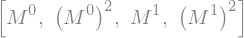

In [3]:
moments = [
    Moment(0),
    Moment(0)**2,
    Moment(1),
    Moment(1)**2
]
display(moments)

### With the automated procedure

The fastest way to generate a closed system of moment equations for the desired set of moment is to call the function `automated_moment_equations()` as follows:

Computed moment equations for desired moments $\left< N\right> $, $\left< N^{2}\right> $, $\left< M^{1}\right> $, and $\left< {\left(M^{1}\right)}^{2}\right> $.

Equations were iteratively added for $\left< M^{2}\right> $ and $\left< N M^{1}\right> $.

Gamma closures were substituted for $\left< N^{2} M^{1}\right> $, $\left< N^{3}\right> $, and $\left< M^{3}\right> $.

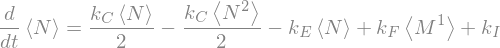

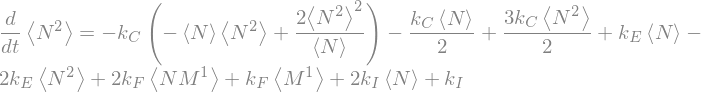

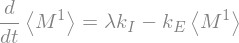

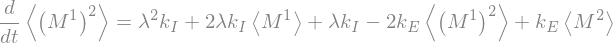

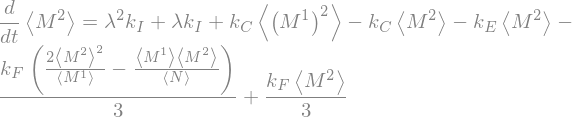

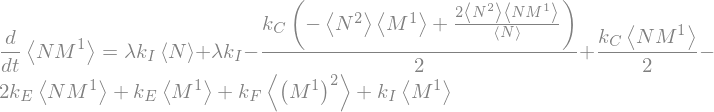

In [4]:
equations = automated_moment_equations(1, transitions, [Moment(0),Moment(0)**2,Moment(1),Moment(1)**2])
display_moment_equations(equations)

### Step-by-step

Alternatively, one can opt for a step-by-step derivation to manually control the construction of the ODE system and the application of moment closure schemes.


We call the function `compute_moment_equations()`, giving the reaction network and the desired moment expressions.

In [5]:
equations = compute_moment_equations(transitions, moments)

To display the derived equations, use the `display_moment_equations()` function.

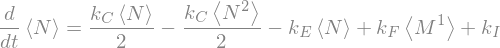

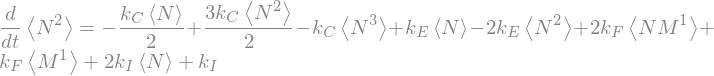

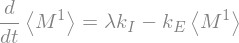

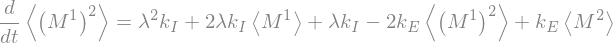

**The system is not closed!** Moment equations are missing for:

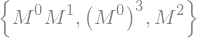

In [6]:
display_moment_equations(equations)

The `display_moment_equations()` function also notifies us that the system is not closed, and which moments are missing. (This output can be suppressed by passing the optional second argument `display_moment_equations(equations, print_missing=False)`).

These "missing" moments are moment expressions whose expectations occur on the right-hand side of equations but which are not governed by the system. They can also be computed using the `get_missing_moments()` function.

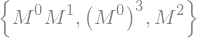

In [7]:
missing = get_missing_moments(equations)
missing

We add the moments below order 3 to the list of moments to derive and iterate the derivation. (We apply gamma closure for 3rd order moments below.)

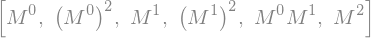

In [8]:
moments = [
    Moment(0),
    Moment(0)**2,
    Moment(1),
    Moment(1)**2,
    Moment(0)*Moment(1),
    Moment(2)
]
display(moments)

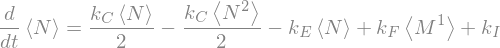

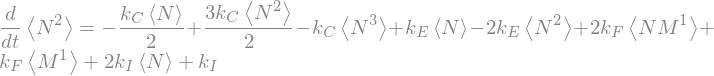

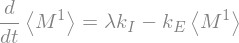

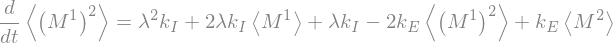

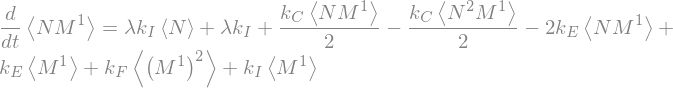

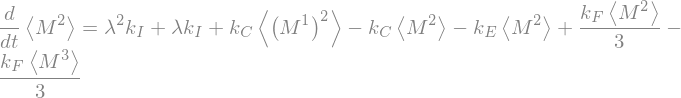

**The system is not closed!** Moment equations are missing for:

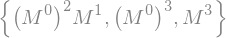

In [9]:
equations = compute_moment_equations(transitions, moments)
display_moment_equations(equations)

## Gamma closure
Next we compute the Gamma closures for the missing moments.

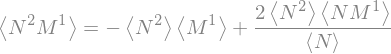

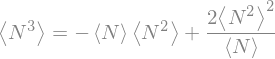

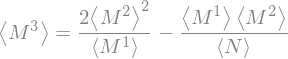

In [10]:
missing = get_missing_moments(equations)
closures = gamma_closures(missing)
display_closures(closures)

Currently, only Gamma closure for 3rd order moments is implemented.
If the closure for an expression can not be computed, the function raises an error.
Alternatively, a list can be supplied as second argument `gamma_closures(expressions, could_not_close)`, and the expressions that could not be closed will be added there (instead or raising an error).

In this example, all of the `missing` expression could be closed, so...

In [11]:
could_not_close=[]
closures = gamma_closures(missing, could_not_close)
could_not_close

We substitute the closures into the moment equations.

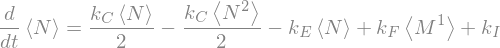

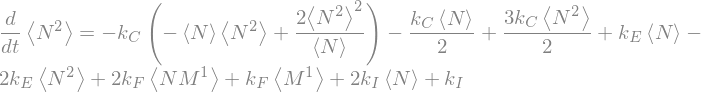

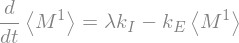

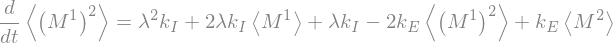

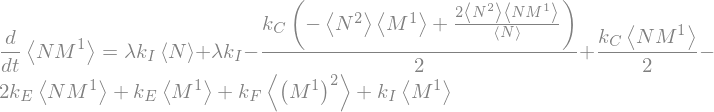

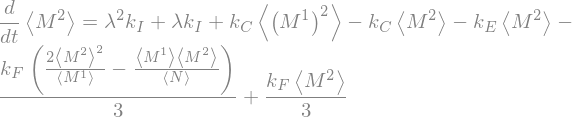

In [12]:
equations = substitute_closures(equations, closures)
display_moment_equations(equations)

## Code generation
From the closed equations, we can generate code for simulating the system.
Currently, Python or Julia code can be generated.
Both derive from a common `AbstractCodeGenerator` class, and it should be relatively straightforward to tweak the code generation for other languages/solvers.

Here, we use the Python generator.

In [13]:
generator = GeneratePython()
code = generator.generate(equations, function_name="coagulation_fragmentation")
exec(code) 

This creates code for two functions, `coagulation_fragmentation_ODEs` and `coagulation_fragmentation_initial`.
The arguments to the functions are listed in the doc strings:

In [14]:
help(coagulation_fragmentation_initial)
help(coagulation_fragmentation_ODEs)

Help on function coagulation_fragmentation_initial in module __main__:

coagulation_fragmentation_initial(initial)
    Create inital expected moments vector
    
    :param initial: tuple of initial values for expectations of (Moment(0,), Moment(1,), Moment(2,))
    :return: initial expected moments vector

Help on function coagulation_fragmentation_ODEs in module __main__:

coagulation_fragmentation_ODEs(M, dM, parameters)
    Evaluate derivatives of expected moments
    
    Indices in M and dM vectors are 
      M[0] = Moment(0,)
      M[1] = Moment(0)**2
      M[2] = Moment(1,)
      M[3] = Moment(1)**2
      M[4] = Moment(0)*Moment(1)
      M[5] = Moment(2,)
    
    :param M: expected moments
    :param dM: result, the derivative dM/dt is stored here
    :param parameters: tuple of values for constants (\lambda, k_C, k_E, k_F, k_I)
    :return: dM



## Solving and plotting results
We use the generated functions with `scipy.solve_ivp` to solve the system.

In [15]:
from scipy.integrate import solve_ivp
import numpy as np

# vector of timepoints where to solve ODE problem
timepoints = np.linspace(0, 100, 1001)

# initial condition
# 100 compartments with 10 molecules each
M0 = coagulation_fragmentation_initial((100, 1000, 10000))

# rate constants and other parameters
kC = 0.005
kF = 0.005
kI = 10.0
kE = 0.1
Lambda = 50
parameters = (Lambda, kC, kE, kF, kI)

# solve
sol = solve_ivp(
    lambda t, M: coagulation_fragmentation_ODEs(M, np.zeros(6), parameters),
    (np.min(timepoints), np.max(timepoints)),
    M0,
    method='BDF',
    t_eval=timepoints)

# print solution of N
print(sol.y[0])

[100.          98.09964031  96.31871186 ... 100.04489169 100.04479285
 100.04470542]


Finally, we use `matplotlib` to plot the solution for mean and standard deviation of $N$.

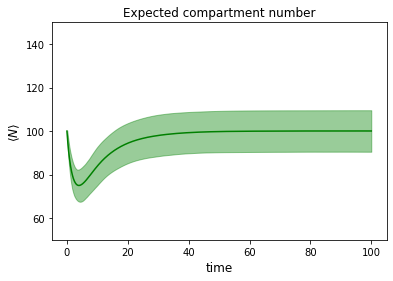

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

y = sol.y
N = y[0]
stdN = np.sqrt(y[1] - N**2)
plt.plot(timepoints, y[0], color="g")
plt.ylabel(r'$\left< N \right>$', size=12)
plt.xlabel('time', size=12)
plt.title("Expected compartment number", size=12)
plt.fill_between(timepoints, N-stdN, N+stdN, alpha=0.4, color="g")
plt.ylim((50,150))